In [1]:
from dotenv import load_dotenv
import sys

sys.path.append("../../common")
load_dotenv()

True

In [2]:
import os
from langsmith_tracker import set_tracking

# 인스턴스를 생성할 때 필요한 매개변수를 전달합니다.
set_tracking(project_name="17.LangGraph-Structures")

Langsmith 추적이 활성화되었습니다. [프로젝트명: 17.LangGraph-Structures]


## Agentic RAG

##### 주요 작업

- LLM 의 판단으로 문서 검색 도구를 활용
- Agent 의 tools_condition 을 통해 도구 사용 여부 결정

##### 그래프 흐름

![Agentic RAG](./assets/langgraph_structures_agentic_rag.png)


In [3]:
from rag.pdf import PDFRetrievalChain

from typing import Annotated, List
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages


# PDF 문서 검색 체인 생성, 체인 안에는 llm 이 포함되어 있음
pdf = PDFRetrievalChain(
    source_uri=["./data/IS-183_AI 위험 유형 및 사례 분석(최종).pdf"]
).create_chain()

pdf_retriever = pdf.retriever
pdf_chain = pdf.chain

#### 1. 문서 파싱 툴 생성

In [4]:
from langchain_core.tools.retriever import create_retriever_tool
from langchain_core.prompts import PromptTemplate

retriever_tool = create_retriever_tool(
    retriever=pdf_retriever,
    name="pdf_retriever",
    description="Search and return information about the SPRI AI Brief PDF file. Contains recent information on AI risks. Published in early 2024.",
    document_prompt=PromptTemplate.from_template(
        "<document><context>{page_content}</context><metadata><source>{source}</source><page>{page}</page></metadata></document>"
    ),
)

tools = [retriever_tool]

#### 2. Agent 상태 정의

In [5]:
from typing_extensions import TypedDict
from typing import Annotated, Sequence
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

#### 3. 노드 정의

In [12]:
from typing import Literal
from langchain import hub
from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import tools_condition


# 최신 모델이름 가져오기
MODEL_NAME = "gpt-4o-mini"


# 데이터 모델 정의
class grade(BaseModel):
    """A binary score for relevance checks"""

    binary_score: str = Field(
        description="Response 'yes' if the document is relevant to the question or 'no' if it is not."
    )


def grade_documents(state) -> Literal["generate", "rewrite"]:
    # LLM 모델 초기화
    model = ChatOpenAI(temperature=0, model=MODEL_NAME, streaming=True)

    # 구조화된 출력을 위한 LLM 설정
    llm_with_tool = model.with_structured_output(grade)

    # 프롬프트 템플릿 정의
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # llm + tool 바인딩 체인 생성
    chain = prompt | llm_with_tool

    # 현재 상태에서 메시지 추출
    messages = state["messages"]

    # 가장 마지막 메시지 추출
    last_message = messages[-1]

    # 원래 질문 추출
    question = messages[0].content

    # 검색된 문서 추출
    retrieved_docs = last_message.content

    # 관련성 평가 실행
    scored_result = chain.invoke({"question": question, "context": retrieved_docs})

    # 관련성 여부 추출
    score = scored_result.binary_score

    # 관련성 여부에 따른 결정
    if score == "yes":
        print("==== [DECISION: DOCS RELEVANT] ====")
        return "generate"

    else:
        print("==== [DECISION: DOCS NOT RELEVANT] ====")
        print(score)
        return "rewrite"


def agent(state):
    # 현재 상태에서 메시지 추출
    messages = state["messages"]

    # LLM 모델 초기화
    model = ChatOpenAI(temperature=0, streaming=True, model=MODEL_NAME)

    # retriever tool 바인딩
    model = model.bind_tools(tools)

    # 에이전트 응답 생성
    response = model.invoke(messages)

    # 기존 리스트에 추가되므로 리스트 형태로 반환
    return {"messages": [response]}


def rewrite(state):
    print("==== [QUERY REWRITE] ====")
    # 현재 상태에서 메시지 추출
    messages = state["messages"]
    # 원래 질문 추출
    question = messages[0].content

    # 질문 개선을 위한 프롬프트 구성
    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # LLM 모델로 질문 개선
    model = ChatOpenAI(temperature=0, model=MODEL_NAME, streaming=True)
    # Query-Transform 체인 실행
    response = model.invoke(msg)

    # 재작성된 질문 반환
    return {"messages": [response]}


def generate(state):
    # 현재 상태에서 메시지 추출
    messages = state["messages"]

    # 원래 질문 추출
    question = messages[0].content

    # 가장 마지막 메시지 추출
    docs = messages[-1].content

    # RAG 프롬프트 템플릿 가져오기
    prompt = hub.pull("teddynote/rag-prompt")

    # LLM 모델 초기화
    llm = ChatOpenAI(model_name=MODEL_NAME, temperature=0, streaming=True)

    # RAG 체인 구성
    rag_chain = prompt | llm | StrOutputParser()

    # 답변 생성 실행
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

#### 4. 그래프 정의, 엣지 설정

In [13]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

# AgentState 기반 상태 그래프 워크플로우 초기화
workflow = StateGraph(AgentState)

# 노드 정의
workflow.add_node("agent", agent)  # 에이전트 노드
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # 검색 노드
workflow.add_node("rewrite", rewrite)  # 질문 재작성 노드
workflow.add_node("generate", generate)  # 관련 문서 확인 후 응답 생성 노드

# 엣지 연결
workflow.add_edge(START, "agent")

# 검색 여부 결정을 위한 조건부 엣지 추가
workflow.add_conditional_edges(
    "agent",
    # 에이전트 결정 평가
    tools_condition,
    {
        # 조건 출력을 그래프 노드에 매핑
        "tools": "retrieve",
        END: END,
    },
)

# 액션 노드 실행 후 처리될 엣지 정의
workflow.add_conditional_edges(
    "retrieve",
    # 문서 품질 평가
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# 그래프 컴파일
graph = workflow.compile(checkpointer=MemorySaver())

#### 5. 시각화

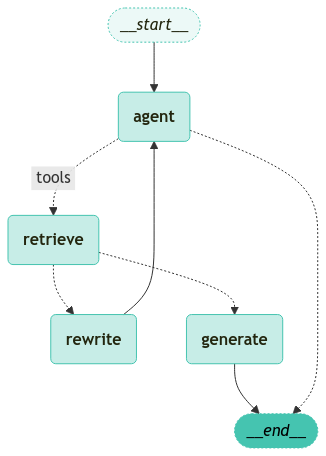

In [14]:
from graphs import visualize_graph

visualize_graph(graph)

#### 6. 그래프 실행

In [18]:
from langchain_core.runnables import RunnableConfig
from langchain_print import stream_graph, invoke_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 사용자의 에이전트 메모리 유형에 대한 질문을 포함하는 입력 데이터 구조 정의
inputs = {
    "messages": [
        ("user", "AI의 악용 사례는?"),
    ]
}

# 그래프 실행
invoke_graph(graph, inputs, config)


🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  pdf_retriever (call_MKIVD7IYNT6mcowYmYM4mTk0)
 Call ID: call_MKIVD7IYNT6mcowYmYM4mTk0
  Args:
    query: AI 악용 사례
==== [DECISION: DOCS RELEVANT] ====

🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: pdf_retriever

<document><context>Ⅲ. AI 위험별 사례 분석 ·······························································11
3.1 악의적 사용 위험 ·····························································11
3.2 오작동 위험 ······································································14</context><metadata><source>./data/IS-183_AI 위험 유형 및 사례 분석(최종).pdf</source><page>2</page></metadata></document>

<document><context>솔루션을 적용하거나, 특수한 경우 모델의 기능 제한이나 사용 제한 같은 극단적인 기술 개입
∙ 하지만 탐지 방법이 개선되어 성능이 향상되어도, 새로운 우회 방법이 등장하여 이용자들이 악용하는
사례가 있으므로 지속적인

In [19]:
# 그래프 스트리밍 출력
stream_graph(graph, inputs, config, ["agent", "rewrite", "generate"])


🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
AI의 악용 사례로는 다음과 같은 것들이 있습니다:

1. **가짜 콘텐츠 생성**: 특정 개인이나 그룹을 대상으로 맞춤 설계된 사기 콘텐츠를 대량으로 생산하여 피해를 유발할 수 있습니다. 이는 사기, 개인 사생활 침해, 명예 훼손 등의 형태로 나타날 수 있습니다.

2. **생물학적 무기 생산**: 대규모 언어 모델(LLM)을 사용하여 심각한 전염병 병원체를 생성하거나 표적화된 생물학적 무기를 빠르게 생산하는 사례가 있습니다. 이는 치명적인 위험을 초래할 수 있습니다.

3. **개인정보 유출**: AI 훈련 데이터에서 개인정보가 유출되거나, 민감한 정보를 검색하고 추론하는 과정에서 개인정보 보호가 침해될 수 있습니다.

4. **저작권 침해**: AI 모델이 학습 과정에서 저작권이 있는 데이터를 대량으로 사용함으로써 저작권 침해 문제가 발생할 수 있습니다.

이러한 사례들은 AI 기술이 발전함에 따라 더욱 심각해질 수 있으며, 이에 대한 지속적인 모니터링과 대응이 필요합니다.

In [20]:
# 문서 검색이 불가능한 질문 예시
inputs = {
    "messages": [
        ("user", "대한민국의 수도는?"),
    ]
}

# 그래프 실행
stream_graph(graph, inputs, config, ["agent", "rewrite", "generate"])


🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
대한민국의 수도는 서울입니다.

In [31]:
from langgraph.errors import GraphRecursionError

config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 문서 검색이 불가능한 질문 예시
inputs = {
    "messages": [
        ("user", "네이버가 개발한 생성형 AI 의 이름은"),
    ]
}

try:
    # 그래프 실행
    stream_graph(graph, inputs, config, ["agent", "rewrite", "generate"])
except GraphRecursionError as recursion_error:
    print(f"GraphRecursionError: {recursion_error}")


🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
==== [DECISION: DOCS NOT RELEVANT] ====
no
==== [QUERY REWRITE] ====

🔄 Node: rewrite 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
네이버가 개발한 생성형 AI의 이름과 그 주요 기능은 무엇인가요?
🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
==== [DECISION: DOCS NOT RELEVANT] ====
no
==== [QUERY REWRITE] ====

🔄 Node: rewrite 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
네이버가 개발한 생성형 AI의 이름과 그 주요 기능은 무엇인가요?
🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
==== [DECISION: DOCS NOT RELEVANT] ====
no
==== [QUERY REWRITE] ====

🔄 Node: rewrite 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
네이버가 개발한 생성형 AI의 이름과 그 주요 기능은 무엇인가요?
🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
GraphRecursionError: Recursion limit of 10 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.lan